In [1]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import os

year_start = 2002
year_end = 2016
wheat_conversion = 3400 #kCals per 1kg of wheat
insecure_threshold = 1800 #must have 1800 Cal/capita/day to be food secure

raw_data_dir = "For_Preprocessing"

usda_raw_dir = "USDA_Crop_Yield_Food_Availabity_Per_Capita"
usda_raw_filename = "gfa25.csv"

wb_ag_raw_dir = "World_Bank_Agricultural_Land"
wb_ag_raw_filename = "API_AG.LND.AGRI.K2_DS2_en_csv_v2_1744410.csv"

forest_raw_dir = "World_Bank_Forest_Land_Percent"
forest_raw_filename = "API_AG.LND.FRST.ZS_DS2_en_csv_v2_1740159.csv"

fert_raw_dir = "World_Bank_Fertilizer_Consumption"
fert_raw_filename = "API_AG.CON.FERT.ZS_DS2_en_csv_v2_1742242.csv"

irrig_raw_dir = "UN_Data_Land_equipped_for_irrigation"
irrig_raw_filename = "UNdata_Export_20201208_035525050.csv"

temper_raw_dir = "Berkeley_Earth_Temperature"
temper_raw_filename = "GlobalLandTemperaturesByCountry.csv"

areas_raw_dir = "Kaggle_Country_Areas"
areas_raw_filename = "countries.csv"

#Read in USDA data
usda_raw_filepath = os.path.join(raw_data_dir, usda_raw_dir, usda_raw_filename)
df_usda = pd.read_csv(usda_raw_filepath,index_col=None, encoding='latin-1')

#Read in WB Agricultural Land data: Back Up
# wb_ag_raw_filepath = os.path.join(raw_data_dir, wb_ag_raw_dir, wb_ag_raw_filename)
# df_agri = pd.read_csv(wb_ag_raw_filepath,index_col=None, encoding='latin-1', header = 4)

#Read in Forest Land Percentage data
forest_raw_filepath = os.path.join(raw_data_dir, forest_raw_dir, forest_raw_filename)
df_forest = pd.read_csv(forest_raw_filepath,index_col=None, encoding='latin-1', header = 2)

#Read in Fertilizer Usage data
fert_raw_filepath = os.path.join(raw_data_dir, fert_raw_dir, fert_raw_filename)
df_fert = pd.read_csv(fert_raw_filepath,index_col=None, encoding='latin-1', header = 2)

#Read in Irrigation data
irrig_raw_filepath = os.path.join(raw_data_dir, irrig_raw_dir, irrig_raw_filename)
df_irrig = pd.read_csv(irrig_raw_filepath,index_col=None, encoding='latin-1')

#Read in Temperature data
temper_raw_filepath = os.path.join(raw_data_dir, temper_raw_dir, temper_raw_filename)
df_temper = pd.read_csv(temper_raw_filepath,index_col=None, encoding='latin-1')
df_temper[['Year','Month', 'First Day']] = df_temper.dt.str.split("-",expand=True) 

#Read in Area data
areas_raw_filepath = os.path.join(raw_data_dir, areas_raw_dir, areas_raw_filename)
df_areas = pd.read_csv(areas_raw_filepath,index_col=None, encoding='latin-1')

#extract unique country names
unique_country_names = df_usda.Country.unique()
total_row_cnt = len(unique_country_names)*(year_end-year_start+1)
df_post = pd.DataFrame(index=range(0,total_row_cnt), columns=['country', 'year', 'forest_land', 'fertilizer', 
                                                              'area_harvested','harvest_area_norm','irrigation','irrigation_norm','temperature', 
                                                              'precipitation', 'GDP','Food_Availability_PC',
                                                              'Daily_Caloric_Intake', 'Food_Insecure'])
row_count = 0
for country in unique_country_names:
    
    temp = df_areas.loc[df_areas['Country'].str.strip() == country, 'Area (sq. mi.)']
    country_area = -1
    if not temp.empty:
            country_area = temp.iloc[0]
    country_area = country_area * 258.999 #convert to Hecta
    #print('Name: ', country)
    #print('Country Area HA: ', country_area)
    for year in range(year_start, year_end+1):
        df_post.iloc[row_count]['country'] = country
        df_post.iloc[row_count]['year'] = year
        
        temp = df_usda.loc[(df_usda['Country'] == country) & (df_usda['Year'] == year) & (df_usda['Commodity'] == 'Total Grains/Cereals') & (df_usda['Item'] == 'Area Harvested'), 'Amount']
        if not temp.empty:
            df_post.iloc[row_count]['area_harvested'] = temp.iloc[0] 
            df_post.iloc[row_count]['harvest_area_norm'] = temp.iloc[0]/country_area
            
        temp = df_usda.loc[(df_usda['Country'] == country) & (df_usda['Year'] == year) & (df_usda['Commodity'] == 'Economic Data') & (df_usda['Item'] == 'GDP (constant 2005 US$)'), 'Amount']
        if not temp.empty:
            df_post.iloc[row_count]['GDP'] = temp.iloc[0] 
            
        temp = df_usda.loc[(df_usda['Country'] == country) & (df_usda['Year'] == year) & (df_usda['Commodity'] == 'Total Grains/Cereals') & (df_usda['Item'] == 'Food Availability per capita'), 'Amount']
        if not temp.empty:
            df_post.iloc[row_count]['Food_Availability_PC'] = temp.iloc[0]
        
        temp = df_forest.loc[(df_forest['Country Name'] == country), str(year)]
        if not temp.empty:
            df_post.iloc[row_count]['forest_land'] = temp.iloc[0]
            
        temp = df_fert.loc[(df_forest['Country Name'] == country), str(year)]
        if not temp.empty:
            df_post.iloc[row_count]['fertilizer'] = temp.iloc[0]
            
        temp = df_irrig.loc[(df_irrig['Country or Area'] == country) & (df_irrig['Year'] == year), 'Value']
        if not temp.empty:
            df_post.iloc[row_count]['irrigation'] = temp.iloc[0]
            df_post.iloc[row_count]['irrigation_norm'] = temp.iloc[0]/country_area
        
        temp = df_temper.loc[(df_temper['Country'] == country) & (df_temper['Year'] == str(year)), 'AverageTemperature']
        if not temp.empty:
            df_post.iloc[row_count]['temperature'] = temp.mean()
        
        temp = df_post.iloc[row_count]['Food_Availability_PC']
        df_post.iloc[row_count]['Daily_Caloric_Intake'] = (temp/365)*wheat_conversion
        
        df_post.iloc[row_count]['Food_Insecure'] = 0
        if df_post.iloc[row_count]['Daily_Caloric_Intake'] < insecure_threshold:
            df_post.iloc[row_count]['Food_Insecure'] = 1
        row_count = row_count + 1
        
df_post.to_csv('data.csv')


In [2]:
df_2013_cal = pd.read_csv('Whole_World/daily-per-capita-caloric-supply.csv',index_col=None)

In [3]:
df_2013_cal = df_2013_cal.loc[df_2013_cal['Year'] == 2013]

In [4]:
df_2013_cal = df_2013_cal.rename(columns={"Code":"iso_a3"})
df_2013_cal.set_index("iso_a3")

,Entity,Year,Caloric_Supply
iso_a3,,,
AFG,Afghanistan,2013,2090.0
NaN,Africa,2013,2624.0
ALB,Albania,2013,3193.0
DZA,Algeria,2013,3296.0
AGO,Angola,2013,2473.0
...,...,...,...
VNM,Vietnam,2013,2745.0
OWID_WRL,World,2013,2884.0
YEM,Yemen,2013,2223.0


In [25]:
df_post

,country,year,forest_land,fertilizer,area_harvested,harvest_area_norm,irrigation,irrigation_norm,temperature,precipitation,GDP,Food_Availability_PC,Daily_Caloric_Intake,Food_Insecure
0,Algeria,2002,0.655739,9.64158,1845.11,2.99108e-06,650,1.05371e-06,24.263,NaN,87156.3,223.774,2084.47,0
1,Algeria,2003,0.652128,6.00117,2901.56,4.7037e-06,785,1.27256e-06,24.3937,NaN,93431.6,226.644,2111.21,0
2,Algeria,2004,0.648517,25.0952,3000.6,4.86425e-06,860,1.39414e-06,23.916,NaN,97449.2,227.581,2119.93,0
3,Algeria,2005,0.644907,7.4299,2350.51,3.8104e-06,980,1.58867e-06,24.2226,NaN,103199,229.619,2138.91,0
4,Algeria,2006,0.676984,13.2627,2672.16,4.33181e-06,1000,1.62109e-06,24.2008,NaN,104953,231.493,2156.37,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1135,Peru,2012,58.1842,94.2501,1258.35,3.7803e-06,2580,7.75076e-06,20.46,NaN,127557,149.709,1394.55,1
1136,Peru,2013,58.0533,94.9095,NaN,NaN,2600,7.81084e-06,19.9763,NaN,NaN,150.801,1404.72,1
1137,Peru,2014,57.9223,112.673,NaN,NaN,2600,7.81084e-06,NaN,NaN,NaN,NaN,NaN,0
1138,Peru,2015,57.7914,141.298,NaN,NaN,2600,7.81084e-06,NaN,NaN,NaN,NaN,NaN,0


/Users/isitatalukdar/opt/anaconda3/lib/python3.8/site-packages/mapclassify/classifiers.py:1714: UserWarning: Warning: Not enough unique values in array to form k classes
  Warn(ms, UserWarning)
/Users/isitatalukdar/opt/anaconda3/lib/python3.8/site-packages/mapclassify/classifiers.py:1715: UserWarning: Warning: setting k to 2
  Warn("Warning: setting k to %d" % uvk, UserWarning)


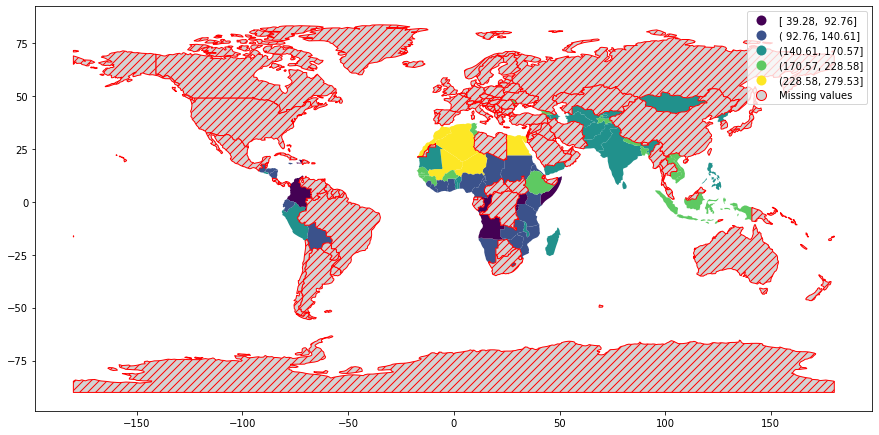

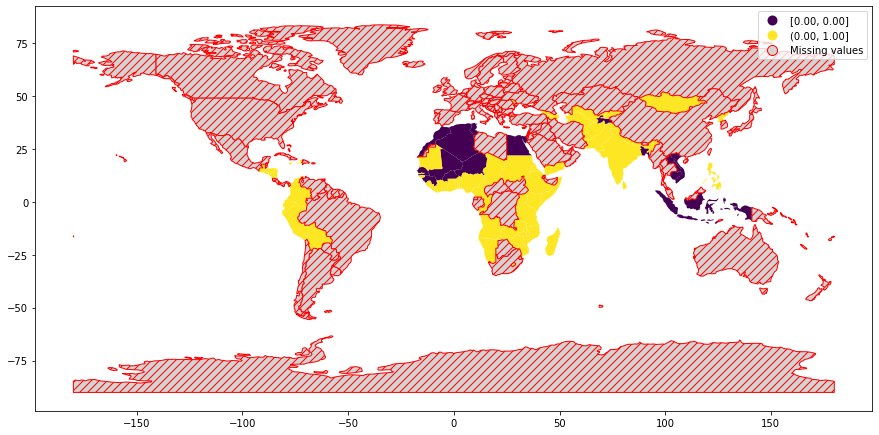

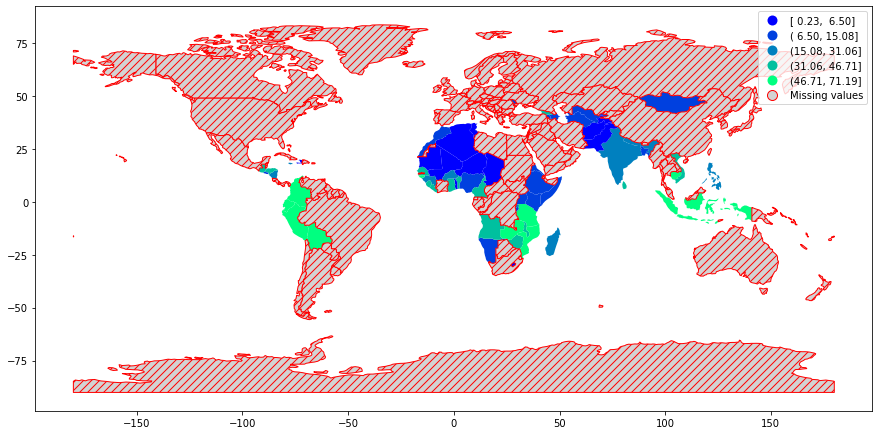

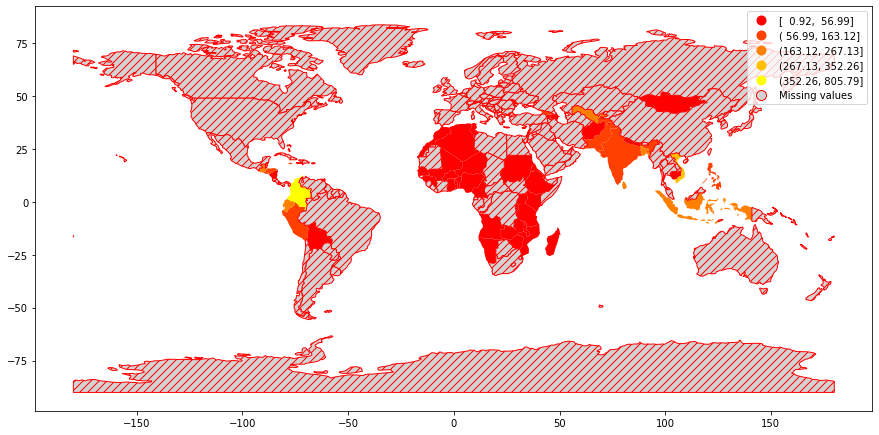

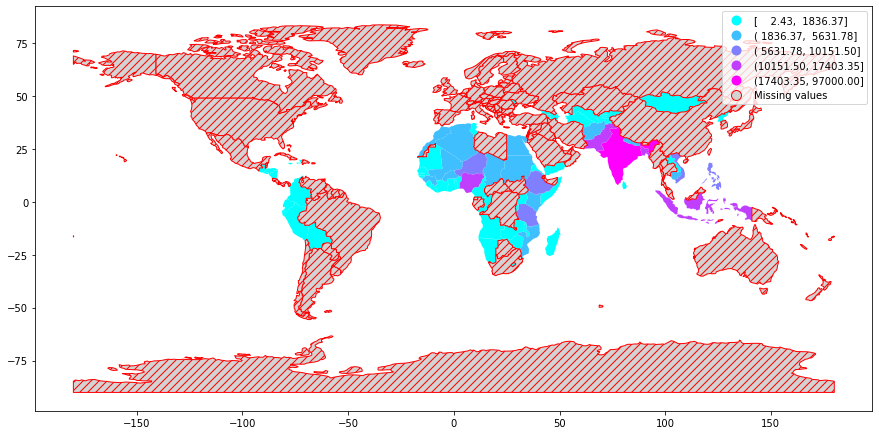

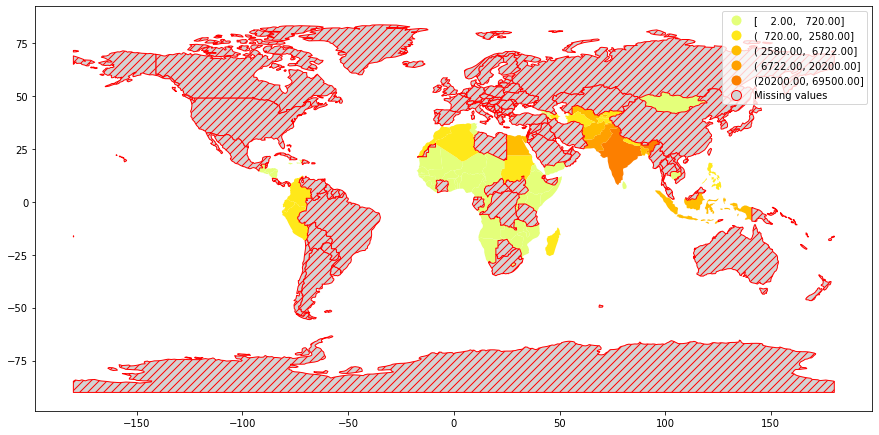

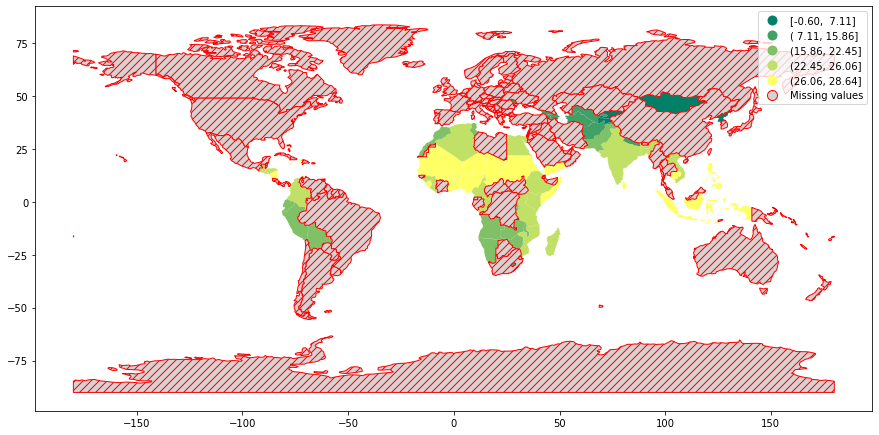

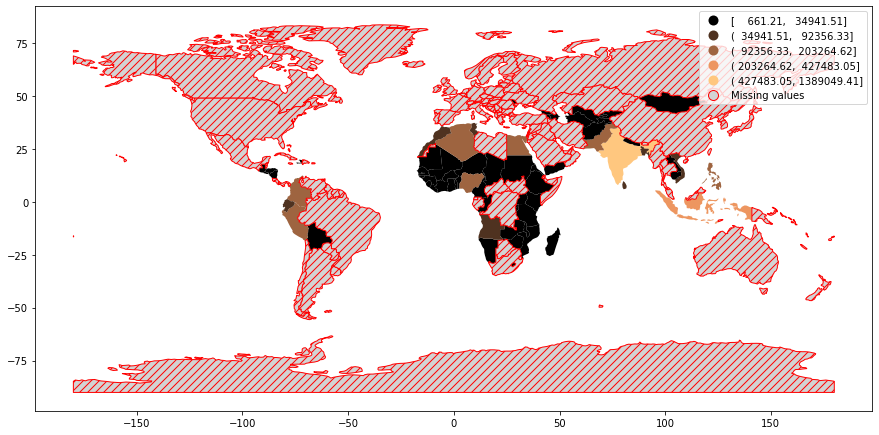

In [34]:
import geopandas
import geoplot

world = geopandas.read_file(
    geopandas.datasets.get_path('naturalearth_lowres')
)
boroughs = geopandas.read_file(
    geoplot.datasets.get_path('nyc_boroughs')
)
collisions = geopandas.read_file(
    geoplot.datasets.get_path('nyc_injurious_collisions')
)

year = 2012
name = "Food_Availability_PC_" + str(year)
name1 = "Food_Insecure" + str(year)
for_land = "Forest_Land" + str(year)
fertilizer = "Fertilizer" + str(year)
har_ar = "Harvest_Area" + str(year)
irrig = "Irrigation" + str(year)
temperature = "Temperature" + str(year)
gdp = "GDP" + str(year)
row_count = 0
for country in list(world["name"]):
    temp = df_post.loc[(df_post['country'] == country) & (df_post['year'] == year), 'Food_Availability_PC']
    if not temp.empty:
            world.loc[row_count, name] = temp.iloc[0]
    temp = df_post.loc[(df_post['country'] == country) & (df_post['year'] == year), 'Food_Insecure']
    if not temp.empty:
            world.loc[row_count, name1] = temp.iloc[0]
    temp = df_post.loc[(df_post['country'] == country) & (df_post['year'] == year), 'forest_land']
    if not temp.empty:
            world.loc[row_count, for_land] = temp.iloc[0]
    temp = df_post.loc[(df_post['country'] == country) & (df_post['year'] == year), 'fertilizer']
    if not temp.empty:
            world.loc[row_count, fertilizer] = temp.iloc[0]
    temp = df_post.loc[(df_post['country'] == country) & (df_post['year'] == year), 'area_harvested']
    if not temp.empty:
            world.loc[row_count, har_ar] = temp.iloc[0]
    temp = df_post.loc[(df_post['country'] == country) & (df_post['year'] == year), 'irrigation']
    if not temp.empty:
            world.loc[row_count, irrig] = temp.iloc[0]
    temp = df_post.loc[(df_post['country'] == country) & (df_post['year'] == year), 'temperature']
    if not temp.empty:
            world.loc[row_count, temperature] = temp.iloc[0]
    temp = df_post.loc[(df_post['country'] == country) & (df_post['year'] == year), 'GDP']
    if not temp.empty:
            world.loc[row_count, gdp] = temp.iloc[0]
    row_count = row_count + 1
    


world.plot(
    column=name,
    legend=True,
    scheme="natural_breaks",
    figsize=(15, 10),
    missing_kwds={
        "color": "lightgrey",
        "edgecolor": "red",
        "hatch": "///",
        "label": "Missing values",
    },
);


world.plot(
    column=name1,
    legend=True,
    scheme="natural_breaks",
    figsize=(15, 10),
    missing_kwds={
        "color": "lightgrey",
        "edgecolor": "red",
        "hatch": "///",
        "label": "Missing values",
    },
);

world.plot(
    column=for_land,
    legend=True,
    cmap = 'winter',
    scheme="natural_breaks",
    figsize=(15, 10),
    missing_kwds={
        "color": "lightgrey",
        "edgecolor": "red",
        "hatch": "///",
        "label": "Missing values",
    },
);

world.plot(
    column=fertilizer,
    legend=True,
    cmap = 'autumn',
    scheme="natural_breaks",
    figsize=(15, 10),
    missing_kwds={
        "color": "lightgrey",
        "edgecolor": "red",
        "hatch": "///",
        "label": "Missing values",
    },
);

world.plot(
    column=har_ar,
    legend=True,
    cmap = 'cool',
    scheme="natural_breaks",
    figsize=(15, 10),
    missing_kwds={
        "color": "lightgrey",
        "edgecolor": "red",
        "hatch": "///",
        "label": "Missing values",
    },
);

world.plot(
    column=irrig,
    legend=True,
    cmap = 'Wistia',
    scheme="natural_breaks",
    figsize=(15, 10),
    missing_kwds={
        "color": "lightgrey",
        "edgecolor": "red",
        "hatch": "///",
        "label": "Missing values",
    },
);

world.plot(
    column=temperature,
    legend=True,
    cmap = 'summer',
    scheme="natural_breaks",
    figsize=(15, 10),
    missing_kwds={
        "color": "lightgrey",
        "edgecolor": "red",
        "hatch": "///",
        "label": "Missing values",
    },
);

world.plot(
    column=gdp,
    legend=True,
    cmap = 'copper',
    scheme="natural_breaks",
    figsize=(15, 10),
    missing_kwds={
        "color": "lightgrey",
        "edgecolor": "red",
        "hatch": "///",
        "label": "Missing values",
    },
);

In [ ]:
print(len(world['Food_Availability_PC_2012']) - world['Food_Availability_PC_2012'].isnull().sum())

In [ ]:
df_post.

In [8]:
world

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,Food_Availability_PC_2012,Food_Insecure2012,Forest_Land2012
0,920938.0,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",NaN,NaN,NaN
1,53950935.0,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",NaN,NaN,NaN
2,603253.0,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948...",NaN,NaN,NaN
3,35623680.0,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",NaN,NaN,NaN
4,326625791.0,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
174,1895250.0,Europe,Kosovo,-99,18490.0,"POLYGON ((20.59025 41.85541, 20.52295 42.21787...",NaN,NaN,NaN
175,1218208.0,North America,Trinidad and Tobago,TTO,43570.0,"POLYGON ((-61.68000 10.76000, -61.10500 10.890...",189.460821,1.0,12.377200
176,13026129.0,Africa,S. Sudan,SSD,20880.0,"POLYGON ((30.83385 3.50917, 29.95350 4.17370, ...",NaN,NaN,NaN
178,NaN,NaN,NaN,NaN,NaN,None,67.611914,1.0,12.380810


In [197]:
world['pop_est']

0         920938
1       53950935
2         603253
3       35623680
4      326625791
         ...    
172      7111024
173       642550
174      1895250
175      1218208
176     13026129
Name: pop_est, Length: 177, dtype: int64

In [ ]:
year = 2013
name = "Food_Availability_PC_" + str(year)
world[name] = 0

row_count = 0
for country in list(world["name"]):
    temp = df_post.loc[(df_post['country'] == country) & (df_post['year'] == year), 'Food_Availability_PC']
    if not temp.empty:
            world.loc[row_count, name] = temp.iloc[0]
    row_count = row_count + 1